In [3]:
%%capture
from scipy.optimize import minimize 
%run EOMs.ipynb
%matplotlib inline

True poincaire sections at constant H would allow us to get a picture of system dynamics as a function of H, which varies adiabatically in the dissipative capture process.

# Symbols & expressions

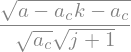

In [4]:
ac = symbols("a_c",positive=True)
H_simp_expr = (
    -Rational(3, 4) * (j + 1) * (j + om / np) * e**4
    - Rational(3, 2) * k * (j + om / np) * e**2
    - 2 * b * sqrt(ap / ac) * mup * e * cos(th)
)
H_simp_expr
H_simp_expr.free_symbols
k_expr = (a-ac)/ac - (j+1)*e**2
Eq(k,k_expr)
solve(Eq(k,k_expr),e)
e_expr_a_k = solve(Eq(k,k_expr),e)[1]
e_expr_a_k

# Poincaire Sections for constant H

THESE ARE NOT CONSTANT ENERGY EITHER BECAUSE GAMMA GOES INTO DENOMINATOR WHERE LAMBDA IS

Wait, no, it only comes in as J1+J2 = Lambda/(j+1)

In [5]:
T_INTEG = 1e4
np_sel = 1.
ap_sel = np_sel**(-2./3)
params = {
    j: 2,
    mup: 1e-3,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 0,  # 12.08476062046314,
    b2_3_2: 0,  # 10.485706741948807,
    ep: 0.01,
    om: 0,
    omp: 0,
    np:np_sel,
    ap:ap_sel,
    "th0":npy.pi/2,
    "thp0":npy.pi/2,
}
nc_sel = (params[j]*np_sel + params[om])/(params[j]+1)
params[ac] = nc_sel**(-2./3)
params["a0"] = params[ac]*0.9

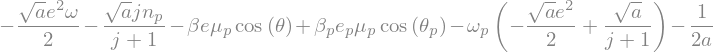

In [6]:
H_expr = - 1/(2*a) - Rational(1,2)*sqrt(a)*e**2*om + mup*bp*ep*cos(thp) - mup*b*e*cos(th) - j*np*sqrt(a)/(j+1) - omp*(sqrt(a)/(j+1)-Rational(1,2)*sqrt(a)*e**2)
H_expr

In [7]:
#_a_func_ek=solve(Eq(k_expr,k),a)[0].subs({ac:ac_sel,j:params[j]})
#display(_a_func_ek)
#a_func_ek = lambdify([e,k],_a_func_ek)
#a_func_ek(e0vals[0],params["k_val"])

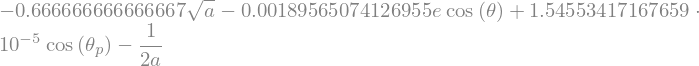

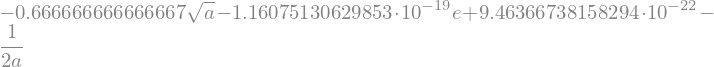

In [8]:
_H = H_expr.subs(params)
display(_H)
display(_H.subs({th:params["th0"],thp:params["thp0"]}))
_H = lambdify([a,e,th,thp], _H)

In [9]:
_e = 0.1
params["H_val"] = _H(params["a0"],_e,params["th0"],params["thp0"])
#params["H_val"] = -1.14471
print(params["H_val"])

-1.1479490932833096


In [10]:
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [ndot, edot, pomdot, thpdot]
]
funs

xp = [n, e, pom, thp, np, t]
funcl = lambdify(xp, funs)


def func(t, x0):
    npval = 1
    return funcl(*x0, npval, t)


def section_thp(t, x0):
    return npy.cos(x0[3])


def section_th(t, x0):
    return npy.cos(x0[3] + params[omp] * t - x0[2])


section_thp.direction = 1
section_th.direction = 1

In [13]:
e0_vals = npy.linspace(0.001, 0.1, 19, endpoint=False)
teval = npy.linspace(0, 2 * npy.pi * T_INTEG, 10000)
sols = []
for _ in e0_vals:
    print(_)
    pom0val = params["thp0"] - params["th0"]
    sol = sp.integrate.solve_ivp(
        func,
        [teval[0], teval[-1]],
        [params["a0"] ** (-3.0 / 2), _, pom0val, params["thp0"]],
        t_eval=teval,
        rtol=1e-9,
        atol=1e-9,
        method="DOP853",
        events=[section_thp, section_th],
    )
    sols += [sol]

0.001
0.006210526315789474
0.011421052631578946
0.01663157894736842
0.021842105263157895
0.02705263157894737
0.03226315789473684
0.03747368421052632
0.04268421052631579
0.04789473684210526
0.05310526315789474
0.05831578947368421
0.06352631578947368
0.06873684210526315
0.07394736842105264
0.07915789473684211
0.08436842105263158
0.08957894736842105
0.09478947368421052


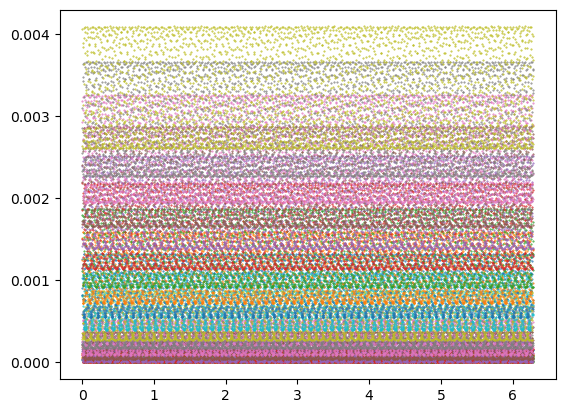

In [14]:
plt.clf()
for sol in sols:
    ev = sol.y_events[0]
    te = sol.t_events[0]
    _a = ev[:,0]
    _thp = ev[:,3] % 2*npy.pi
    _pom = ev[:,2]
    _th = (_thp + te*params[omp]-_pom) %(2*npy.pi)
    Le = npy.sqrt(_a)
    Ge = 0.5*npy.sqrt(ev[:,0])*ev[:,1]**2
    J = Le/(params[j]+1) - Ge
    #plt.scatter(_thp,J,s=0.2)
    plt.scatter(_th,Ge,s=0.2)
plt.show()